In [1]:
!pip install scipy

In [2]:
import numpy as np
from scipy.stats import multivariate_normal

class GaussianMixture:
    def __init__(self, n_components=2, max_iter=100, tol=1e-4):
        """
        Initialize a Gaussian Mixture Model

        Parameters:
        -----------
        n_components : int
            Number of Gaussian components
        max_iter : int
            Maximum number of EM iterations
        tol : float
            Convergence threshold for log-likelihood
        """
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def initialize_parameters(self, X):
        """Initialize means, covariances, and mixing coefficients"""
        n_samples, n_features = X.shape

        # Randomly initialize means using points from the dataset
        random_idx = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[random_idx]

        # Initialize covariances as diagonal matrices
        self.covs = np.array([np.eye(n_features) for _ in range(self.n_components)])

        # Initialize mixing coefficients with equal weights
        self.weights = np.ones(self.n_components) / self.n_components

    def e_step(self, X):
        """Expectation step: compute responsibilities"""
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            responsibilities[:, k] = self.weights[k] * multivariate_normal.pdf(
                X, mean=self.means[k], cov=self.covs[k]
            )

        # Normalize responsibilities
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        return responsibilities

    def m_step(self, X, responsibilities):
        """Maximization step: update parameters"""
        n_samples = X.shape[0]

        # Update weights (mixing coefficients)
        nk = responsibilities.sum(axis=0)
        self.weights = nk / n_samples

        # Update means
        self.means = np.dot(responsibilities.T, X) / nk[:, np.newaxis]

        # Update covariances
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covs[k] = np.dot(responsibilities[:, k] * diff.T, diff) / nk[k]

    def compute_log_likelihood(self, X):
        """Compute log-likelihood of the data"""
        n_samples = X.shape[0]
        likelihood = np.zeros((n_samples, self.n_components))

        for k in range(self.n_components):
            likelihood[:, k] = self.weights[k] * multivariate_normal.pdf(
                X, mean=self.means[k], cov=self.covs[k]
            )

        return np.sum(np.log(likelihood.sum(axis=1)))

    def fit(self, X):
        """Fit the Gaussian Mixture Model to the data"""
        self.initialize_parameters(X)

        prev_log_likelihood = -np.inf

        for iteration in range(self.max_iter):
            # E-step
            responsibilities = self.e_step(X)

            # M-step
            self.m_step(X, responsibilities)

            # Check convergence
            log_likelihood = self.compute_log_likelihood(X)
            if abs(log_likelihood - prev_log_likelihood) < self.tol:
                break

            prev_log_likelihood = log_likelihood

        return self

    def predict_proba(self, X):
        """Compute probabilities of samples belonging to each component"""
        return self.e_step(X)

    def sample(self, n_samples):
        """Generate random samples from the fitted GMM"""
        # Choose components based on weights
        components = np.random.choice(
            self.n_components, size=n_samples, p=self.weights
        )

        # Generate samples from chosen components
        samples = np.zeros((n_samples, self.means.shape[1]))
        for k in range(self.n_components):
            mask = components == k
            n_k = mask.sum()
            if n_k > 0:
                samples[mask] = np.random.multivariate_normal(
                    self.means[k], self.covs[k], size=n_k
                )

        return samples

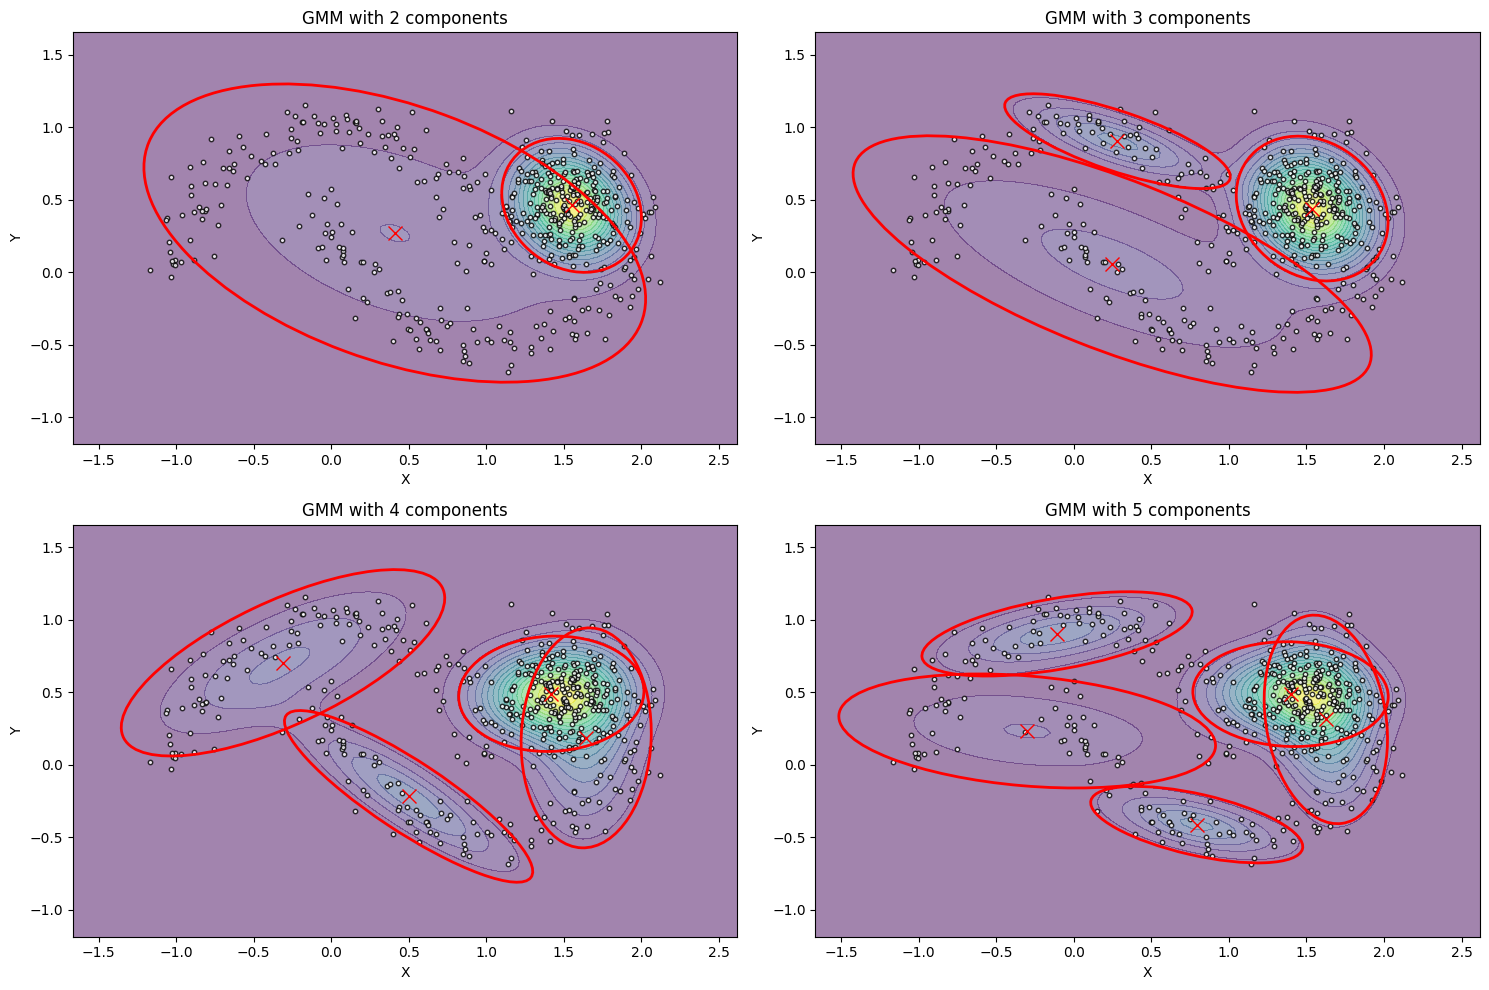

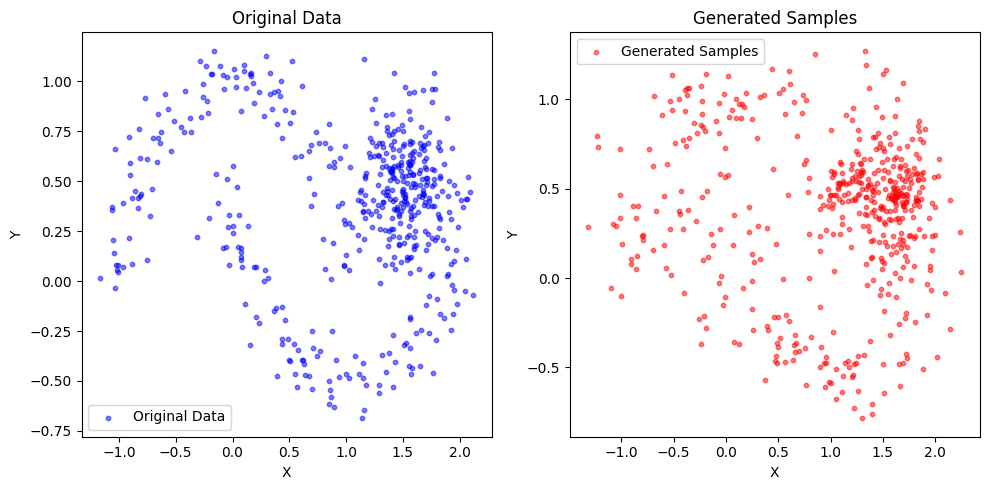


Learned Parameters for 4-component GMM:

Mixing Coefficients (weights):
Component 1: 0.120
Component 2: 0.288
Component 3: 0.098
Component 4: 0.126
Component 5: 0.368

Means:
Component 1: [-0.300, 0.232]
Component 2: [1.625, 0.312]
Component 3: [0.793, -0.414]
Component 4: [-0.107, 0.902]
Component 5: [1.398, 0.486]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# First, let's create some interesting data - a mixture of a moon shape and a cluster
def create_mixed_dataset(n_samples=300):
    # Create moon-shaped data
    X_moons, _ = make_moons(n_samples=n_samples//2, noise=0.1, random_state=42)

    # Create a Gaussian cluster
    cluster = np.random.randn(n_samples//2, 2) * 0.2 + np.array([1.5, 0.5])

    # Combine the datasets
    X = np.vstack([X_moons, cluster])

    return X

# Create the dataset
X = create_mixed_dataset(500)

# Fit GMM with different numbers of components
n_components_range = [2, 3, 4, 5]
plt.figure(figsize=(15, 10))

for idx, n_components in enumerate(n_components_range, 1):
    # Create and fit the GMM
    gmm = GaussianMixture(n_components=n_components, max_iter=200)
    gmm.fit(X)

    # Create a mesh grid for visualization
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                        np.linspace(y_min, y_max, 100))

    # Compute probabilities for each point in the mesh
    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    Z = np.zeros(mesh_points.shape[0])

    for k in range(n_components):
        Z += gmm.weights[k] * multivariate_normal.pdf(
            mesh_points,
            mean=gmm.means[k],
            cov=gmm.covs[k]
        )

    Z = Z.reshape(xx.shape)

    # Plot the results
    plt.subplot(2, 2, idx)
    plt.contourf(xx, yy, Z, levels=20, cmap='viridis', alpha=0.5)
    plt.scatter(X[:, 0], X[:, 1], c='white', s=10, alpha=0.8, edgecolor='black')

    # Plot the component means and covariance ellipses
    for k in range(n_components):
        eigenvals, eigenvecs = np.linalg.eigh(gmm.covs[k])
        angle = np.arctan2(eigenvecs[1, 0], eigenvecs[0, 0])
        angle = 180 * angle / np.pi

        # Plot 95% confidence ellipse
        for nstd in [2]:  # 2 standard deviations = 95% confidence
            width, height = 2 * nstd * np.sqrt(eigenvals)
            ell = plt.matplotlib.patches.Ellipse(
                gmm.means[k], width, height,
                angle=angle, fill=False, color='red', linewidth=2
            )
            plt.gca().add_patch(ell)

        # Plot the mean
        plt.plot(gmm.means[k, 0], gmm.means[k, 1], 'rx', markersize=10)

    plt.title(f'GMM with {n_components} components')
    plt.xlabel('X')
    plt.ylabel('Y')

plt.tight_layout()
plt.show()

# Generate new samples
plt.figure(figsize=(10, 5))

# Plot original data
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c='blue', s=10, alpha=0.5, label='Original Data')
plt.title('Original Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# Generate and plot samples
plt.subplot(1, 2, 2)
samples = gmm.sample(500)  # Generate same number of samples as original data
plt.scatter(samples[:, 0], samples[:, 1], c='red', s=10, alpha=0.5, label='Generated Samples')
plt.title('Generated Samples')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

plt.tight_layout()
plt.show()

# Print the learned parameters for the best model (using 4 components)
print("\nLearned Parameters for 4-component GMM:")
print("\nMixing Coefficients (weights):")
for i, w in enumerate(gmm.weights):
    print(f"Component {i + 1}: {w:.3f}")

print("\nMeans:")
for i, mean in enumerate(gmm.means):
    print(f"Component {i + 1}: [{mean[0]:.3f}, {mean[1]:.3f}]")